# Analysis of SpaceX Contracts, Customers, and KPIs

This notebook is a follow-up to [Contracts and Financial Calculations](https://github.com/brittabeta/Space-X-to-Y-Data-Analysis-and-Landing-Predictions).

The goal of this notebook is to utilize known SpaceX contract amounts divided by the number of missions within the contract to guide cost (expense) estimates and bidding (revenue) amount proposals for SpaceY.

# Outline

* [Introduction](#section-one)
* [Exploratory data analysis](#section-two)
    - [Initial Exploration](#subsection-one)
    - [Further Analysis](#subsection-two)
    - [Correlation of Variables](#subsection-three)
* [Financial calculations](#section-three)
    - [Evaluation](#subsection-four)
* [Robust Regression and LOOCV](#section-robust)
* [Conclusions](#section-four)

<a id="section-one"></a>
# Introduction

[Data source](https://www.elonx.net/list-of-spacex-contracts/) provides collected information on Contract Date, Mission Name, Total Price, Number of Launches, Per Lauch Price, Customer, Booster Type, Recoverable, Notes in Google Sheets format.  This was matched by Mission Name with [SpaceX API](https://github.com/brittabeta/Space-X-to-Y-Data-Analysis-and-Landing-Predictions) data collection.

### Components
* First Stage (Core, Booster with Serial# and Block/Version)
* Second Stage (Payload mass within fairings)

![Falcon 9 Components](https://zlsadesign.com/infographic/vehicle/spacex-falcon9-scale.png)

<a id="section-two"></a>
# Exploratory Data Analysis

In [1]:
# import initial tools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# for visuals
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline 
import warnings ## importing warnings library. 
warnings.filterwarnings('ignore') ## Ignore warning

In [2]:
random_seed = 42

<a id="subsection-one"></a>
## Initial Exploration

In [3]:
# load merged contract information
df = pd.read_csv("/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex_contracts_customers_known_revenue.csv")

In [4]:
df.head()

,FlightNumber,Date,Mission,RevenuePerLaunch,Customer,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,...,ReusedCore,Legs,Block,ReusedCount,Serial,Longitude,Latitude,Class,Year,ReusedFairings
0,3,3/1/2013,CRS (original contract),133300000,NASA,Falcon 9,677,ISS,CCAFS SLC 40,None None,...,0,0,1,0,B0007,-80.577366,28.561857,0,2013,0
1,7,4/18/2014,CRS (original contract),133300000,NASA,Falcon 9,2296,ISS,CCAFS SLC 40,True Ocean,...,0,1,1,0,B1006,-80.577366,28.561857,1,2014,0
2,9,8/5/2014,AsiaSat 6,52200000,AsiaSat,Falcon 9,4535,GTO,CCAFS SLC 40,None None,...,0,0,1,0,B1008,-80.577366,28.561857,0,2014,0
3,10,9/7/2014,AsiaSat 8,52200000,AsiaSat,Falcon 9,4428,GTO,CCAFS SLC 40,None None,...,0,0,1,0,B1011,-80.577366,28.561857,0,2014,0
4,11,9/21/2014,CRS (original contract),133300000,NASA,Falcon 9,2216,ISS,CCAFS SLC 40,False Ocean,...,0,0,1,0,B1010,-80.577366,28.561857,0,2014,0


In [5]:
# get #of rows, columns, get column names and data types, get number of null values
df.info()
# no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FlightNumber      28 non-null     int64  
 1   Date              28 non-null     object 
 2   Mission           28 non-null     object 
 3   RevenuePerLaunch  28 non-null     int64  
 4   Customer          28 non-null     object 
 5   BoosterVersion    28 non-null     object 
 6   PayloadMass       28 non-null     int64  
 7   Orbit             28 non-null     object 
 8   LaunchSite        28 non-null     object 
 9   Outcome           28 non-null     object 
 10  Flights           28 non-null     int64  
 11  GridFins          28 non-null     int64  
 12  ReusedCore        28 non-null     int64  
 13  Legs              28 non-null     int64  
 14  Block             28 non-null     int64  
 15  ReusedCount       28 non-null     int64  
 16  Serial            28 non-null     object 
 17 

In [6]:
# organize data, eliminate columns not needed
categorical = ['Mission','Customer', 'Orbit', 'LaunchSite', 'Outcome', 'Serial']
numeric = ['FlightNumber','PayloadMass', 'Flights', 'GridFins', 'ReusedCore', 'Legs', 
           'Block', 'ReusedCount', 'Class', 'Year', 'ReusedFairings']
target = ['RevenuePerLaunch']
# join the 
df = df[categorical + numeric + target]

In [7]:
df.columns

Index(['Mission', 'Customer', 'Orbit', 'LaunchSite', 'Outcome', 'Serial',
       'FlightNumber', 'PayloadMass', 'Flights', 'GridFins', 'ReusedCore',
       'Legs', 'Block', 'ReusedCount', 'Class', 'Year', 'ReusedFairings',
       'RevenuePerLaunch'],
      dtype='object')

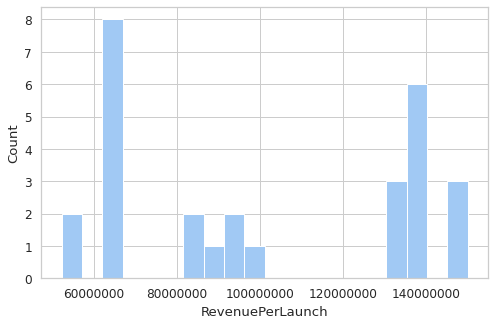

In [8]:
sns.set(style='whitegrid', palette="pastel", font_scale=1.1, rc={"figure.figsize": [8, 5]})
plt.ticklabel_format(style='plain', axis='x')
sns.distplot(
    df['RevenuePerLaunch'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
            ).set(xlabel='RevenuePerLaunch', ylabel='Count');

In [9]:
df['RevenuePerLaunch'].describe().apply("{0:.5f}".format)

count           28.00000
mean     101641428.57143
std       36407745.99249
min       52200000.00000
25%       64720000.00000
50%       92600000.00000
75%      140000000.00000
max      150000000.00000
Name: RevenuePerLaunch, dtype: object

* revenue per launch does not have a normal distribution

In [10]:
df.describe()

,FlightNumber,PayloadMass,Flights,GridFins,ReusedCore,Legs,Block,ReusedCount,Class,Year,ReusedFairings,RevenuePerLaunch
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.0,2.800000e+01
mean,33.821429,4310.821429,1.178571,0.785714,0.178571,0.785714,2.785714,0.928571,0.642857,2016.571429,0.0,1.016414e+08
std,23.866998,3300.372359,0.390021,0.417855,0.390021,0.417855,1.595297,1.245096,0.487950,1.932731,0.0,3.640775e+07
min,3.000000,350.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2013.000000,0.0,5.220000e+07
25%,13.750000,2246.750000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2015.000000,0.0,6.472000e+07
50%,29.500000,3023.000000,1.000000,1.000000,0.000000,1.000000,3.000000,1.000000,1.000000,2017.000000,0.0,9.260000e+07
75%,47.500000,5801.250000,1.000000,1.000000,0.000000,1.000000,4.000000,1.000000,1.000000,2018.000000,0.0,1.400000e+08
max,90.000000,9600.000000,2.000000,1.000000,1.000000,1.000000,5.000000,5.000000,1.000000,2020.000000,0.0,1.500000e+08


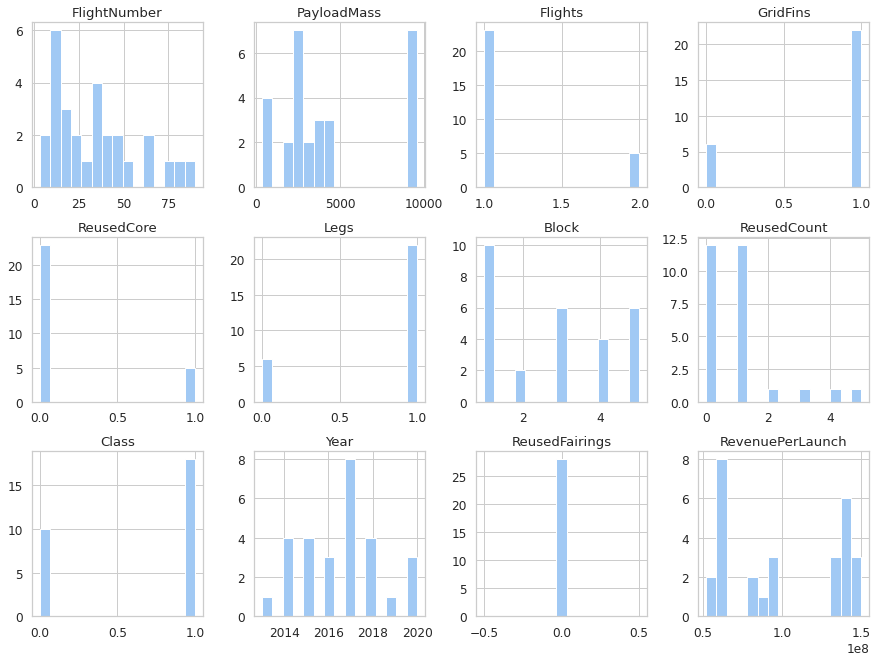

In [11]:
df.hist(bins=15, figsize=(15, 6), layout=(3, 4))
plt.subplots_adjust(top=1.5, wspace=0.3)

Distribution
* Revenue per launch distribution peaks at both extremes
* Payload mass does not have a normal distribution, skewed towards lower payloads, with several higher values
* Year has a distribution over all years, most 2017

Unbalanced data
* New core flights > representation
* Class, landing success > representation
* Reused fairings are not in this data

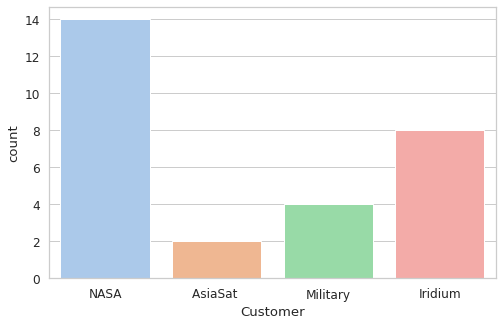

In [12]:
# flight count by Customer
sns.color_palette("pastel")
sns.countplot(df['Customer']);

* Top private sector customer in the dataset is Iridium 
* Top public sector customer in the dataset is NASA
* Unbalanced: public sector customers > representation

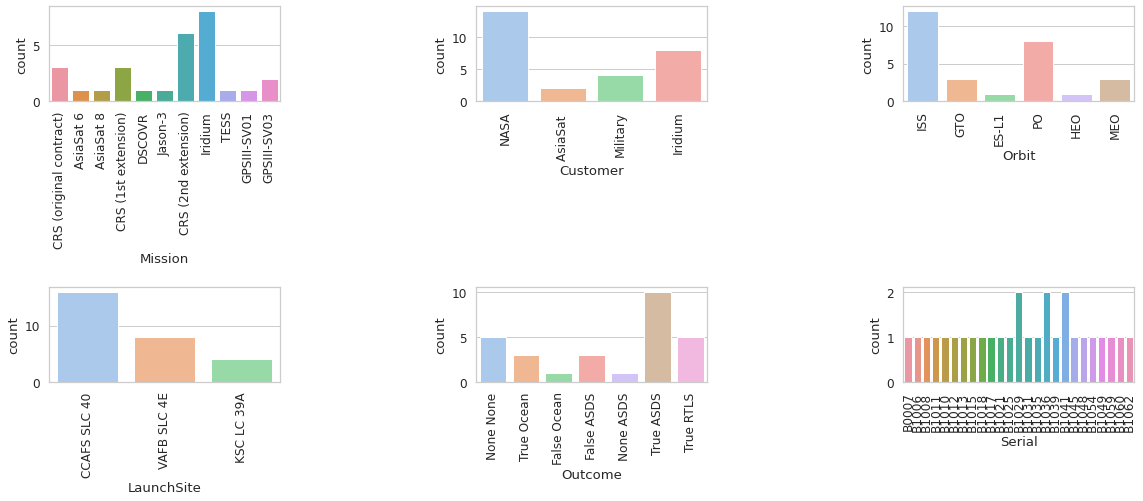

In [13]:
# visualize distribution of categorical variables
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
fig.tight_layout(pad=12.0)
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

* Most missions in the dataset are CRS, which is a NASA contract, followed by the Iridium contract
* Most missions are to Orbit ISS, International Space Station, this is NASA and = LEO orbit
* About 2/3rds of the missions land successfully

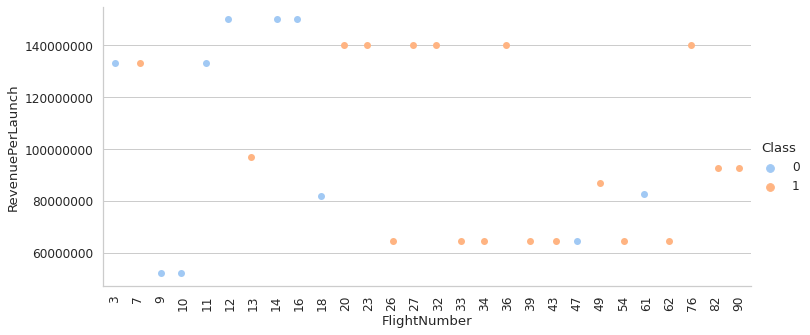

In [14]:
# look at revenue per launch overtime along with success rate
sns.catplot(y = 'RevenuePerLaunch', x = 'FlightNumber', hue = 'Class', data=df, height=5, aspect=2, s = 7)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.show()

* variance of revenue per launch seems large, but may be converging
* landing success has increased overtime, lower revenue later flights had more failed landings


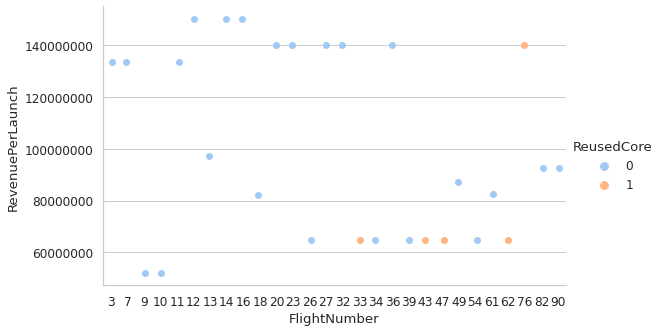

In [15]:
# look at revenue over time and core reuse
sns.catplot(y = 'RevenuePerLaunch', x = 'FlightNumber', hue = 'ReusedCore', data=df, height=5, aspect=1.5, s=7)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

* missions using reused cores seem to cost less exception = flight 76

In [16]:
flight76 = df.iloc[-3,:]
flight76

Mission             CRS (2nd extension)
Customer                           NASA
Orbit                               ISS
LaunchSite                 CCAFS SLC 40
Outcome                       True RTLS
Serial                            B1059
FlightNumber                         76
PayloadMass                        1977
Flights                               2
GridFins                              1
ReusedCore                            1
Legs                                  1
Block                                 5
ReusedCount                           3
Class                                 1
Year                               2020
ReusedFairings                        0
RevenuePerLaunch              140000000
Name: 25, dtype: object

Flight 76 does not appear to have any reason for costing so much, payload mass is below average, reused core, it landed successfully, it was going to ISS.  There must have been other factors involved that we do not have data to describe

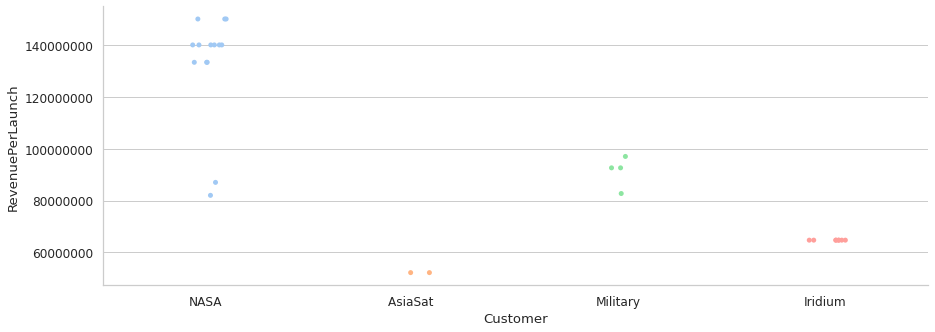

In [17]:
sns.catplot(y = 'RevenuePerLaunch', x = 'Customer', hue = 'Customer', data=df, height=5, aspect=2.5)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

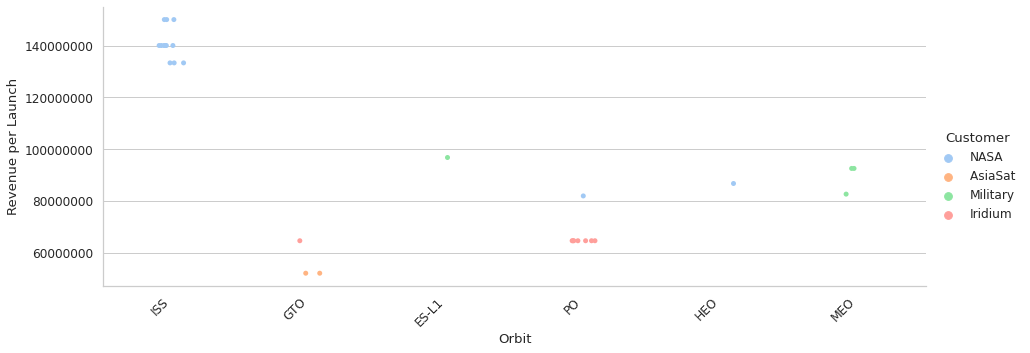

In [18]:
sns.catplot(y = 'RevenuePerLaunch', x = 'Orbit', hue = 'Customer', data=df, height=5, aspect=2.5)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Revenue per Launch')
plt.xticks(rotation=45, ha='right')
plt.show()

* ISS mission contracts, NASA, show the highest revenue per launch
* AsiaSat and Iridium GTO and PO mission contracts show the lowest revenue per launch

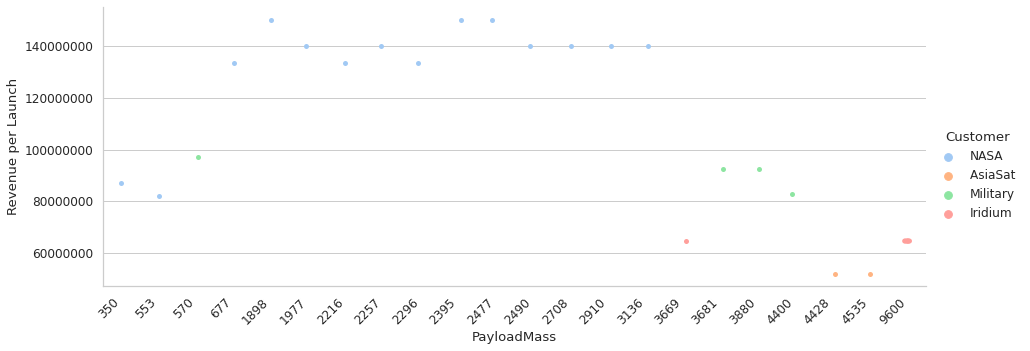

In [19]:
sns.catplot(y = 'RevenuePerLaunch', x = 'PayloadMass', hue = 'Customer', data=df, height=5, aspect=2.5)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Revenue per Launch')
plt.xticks(rotation=45, ha='right')
plt.show()

Either possibility may be dependent upon customer type (or other factors), most contract data is for NASA (and Military in Green), 
* lower payload mass: NASA or Military contracts
* high payload mass: Iridium and AsiaSat, along with a few military
* as payload mass increases revenue per launch decreases with the exception of 3 data points 350 kg, 553 kg, and 570 kg (NASA and military)

<a id="subsection-two"></a>
## Further Exploration

#### Customers by Type

In [20]:
# create subsets of customers: private sector (Iridium, Asiasat) and public (NASA, Military)
# add column based on customer type
def customer_type(row):
    if (row['Customer'] == 'Iridium') | (row['Customer'] == 'AsiaSat '):
        return 'Private'
    elif (row['Customer'] == 'NASA') | (row['Customer'] == 'Military'):
        return 'Public'
# apply defined function
df['CustomerType'] = df.apply(lambda row: customer_type(row), axis = 1)

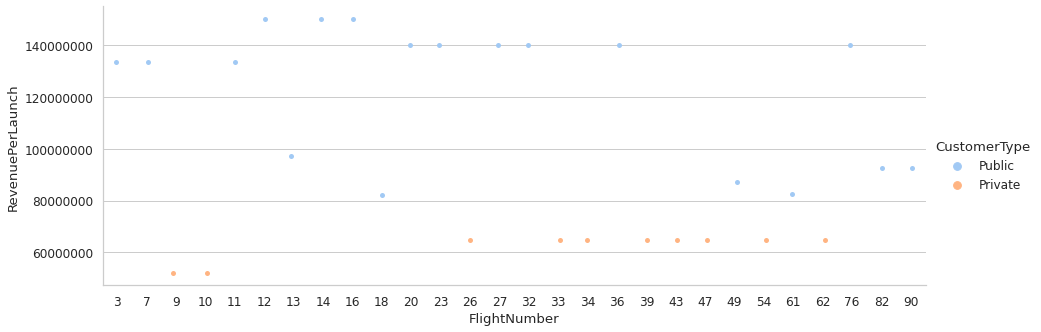

In [21]:
sns.catplot(y = 'RevenuePerLaunch', x = 'FlightNumber', hue = 'CustomerType', data=df, height=5, aspect=2.5)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

* private customer type: missions (number of) have increased overtime, prices may be increasing (again x axis is not equally divided)
* public customer type: missions seem to cost more than private customer missions public customer mission prices may be decreasing (again x axis is not equally divided)

In [22]:
# lets create subsets of private and public contracts
df_private = df.loc[df['CustomerType'] == 'Private']
df_public = df.loc[df['CustomerType'] == 'Public']

<AxesSubplot:xlabel='RevenuePerLaunch', ylabel='Count'>

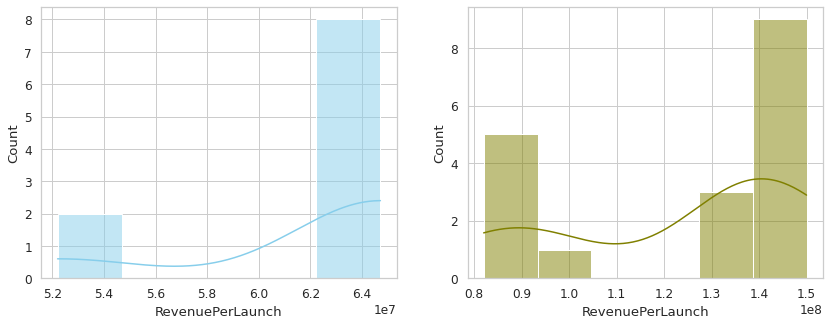

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=df_private, x="RevenuePerLaunch", kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=df_public, x="RevenuePerLaunch", kde=True, color="olive", ax=axs[1])

* When data is subset by public and private customers, revenue per launch still does not have a normal distribution

<AxesSubplot:xlabel='PayloadMass', ylabel='Count'>

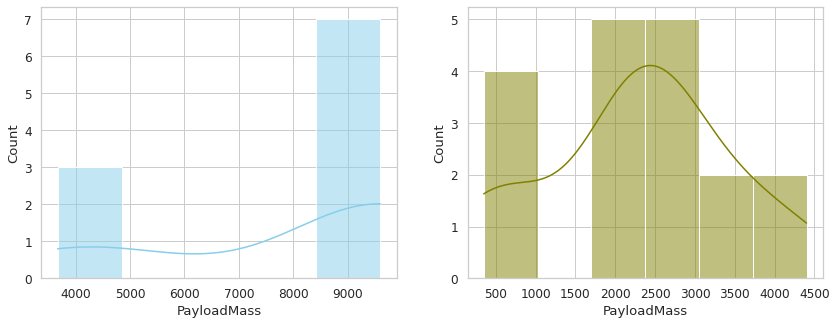

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=df_private, x="PayloadMass", kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=df_public, x="PayloadMass", kde=True, color="olive", ax=axs[1])

* Payload mass (Private Customers): not normally distributed, dataset is small
* Payload mass (Public Customers): a somewhat normal distribution appears

<a id="subsection-three"></a>
## Correlation of Variables

#### Statistical measures of Correlation between variables

In [25]:
# prepare data
y1 = df_private['RevenuePerLaunch']
X1 = df_private.iloc[:,:-1]
y2 = df_public['RevenuePerLaunch']
X2 = df_public.iloc[:,:-1]

In [26]:
# import scipy 
import scipy.stats as st
from scipy.stats import linregress, pearsonr, spearmanr, kendalltau

#### Private Customers and Payload Mass

In [28]:
# visualize revenue vs payload: linear for private customers?
slope, intercept, r, p, stderr = st.linregress(X1['PayloadMass'], y1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

'Regression line: y=50823002.03+1427.12x, r=0.71'

In [29]:
# calculate Pearson's correlation coefficient (but assumes normal distribution)
corr, p = pearsonr(X1['PayloadMass'], y1)
print('Pearsons correlation: %.3f' % corr, 'p=%.3f' % p)

Pearsons correlation: 0.706 p=0.022


In [30]:
# calculate the confidence interval
st.t.interval(alpha=0.95, df=len(df_private['RevenuePerLaunch'])-1, loc=np.mean(df_private['RevenuePerLaunch']), scale=st.sem(df_private['RevenuePerLaunch'])) 

(58439705.642997704, 65992294.357002296)

* the correlation coefficient, 95 percent CI, and p-value seem to point to a linear relationship when looking at private customers

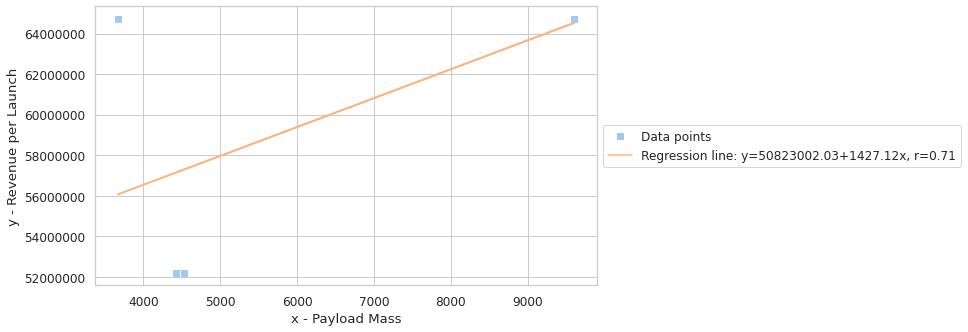

In [31]:
fig, ax = plt.subplots()
ax.plot(X1['PayloadMass'], y1, linewidth=0, marker='s', label='Data points')
ax.plot(X1['PayloadMass'], intercept + slope * X1['PayloadMass'], label=line)
ax.set_xlabel('x - Payload Mass')
ax.set_ylabel('y - Revenue per Launch')
fig.tight_layout()
ax.legend(facecolor='white', loc='center left', bbox_to_anchor=(1, 0.5))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

* Private Customers: Positive slope - as payload mass increases, revenue per launch increases
* Does this make since?

In [32]:
# set x to 5000 kg
x=5000
y=50823002.03+1427.12*x
y

57958602.03

In [33]:
# calculate spearman's correlation 
corr, p = spearmanr(df_private['RevenuePerLaunch'], df_private['PayloadMass'])
print('Spearmans correlation: %.3f' % corr, 'p=%.3f' % p)

Spearmans correlation: 0.643 p=0.045


* spearman's correlation coefficient agrees, that for the private sector, payload mass is a feature that determines contract price

* revenue per launch of 57 million is below the asking price for a new core of 62 million and greater than the asking price for a reused core of 50 million.  This seems reasonable.

#### Public Customers and Payload Mass

In [35]:
# visualize revenue vs payload: linear for public customers?
slope, intercept, r, p, stderr = st.linregress(X2['PayloadMass'], y2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

'Regression line: y=121574188.56+867.72x, r=0.04'

In [36]:
# calculate Pearson's correlation coefficient (but assumes normal distribution, may be more appropriate here)
corr, p = pearsonr(X2['PayloadMass'], y2)
print('Pearsons correlation: %.3f' % corr, 'p=%.3f' % p)

Pearsons correlation: 0.039 p=0.878


* pearson's correlation coefficient and p-value both indicate that these variable do not have a linear relationship for public customers

In [37]:
# calculate spearman's correlation 
corr, p = spearmanr(df_public['RevenuePerLaunch'], df_public['PayloadMass'])
print('Spearmans correlation: %.3f' % corr, 'p=%.3f' % p)

Spearmans correlation: 0.074 p=0.771


* spearmans (which does not assume normal distribution or linear relationship) seems to say for the public sector, payload mass is not the deciding factor for contract price

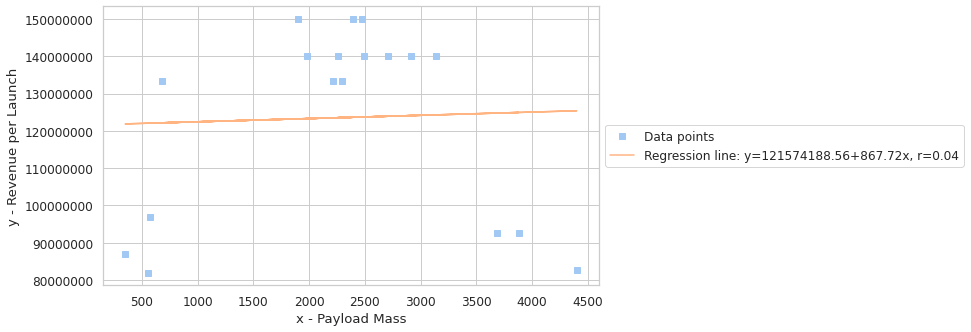

In [38]:
fig, ax = plt.subplots()
ax.plot(X2['PayloadMass'], y2, linewidth=0, marker='s', label='Data points')
ax.plot(X2['PayloadMass'], intercept + slope * X2['PayloadMass'], label=line)
ax.set_xlabel('x - Payload Mass')
ax.set_ylabel('y - Revenue per Launch')
fig.tight_layout()
ax.legend(facecolor='white', loc='center left', bbox_to_anchor=(1, 0.5))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

* Payload mass is an important feature in determining contract price for private customers, but not for NASA and the military

#### Looking at Categorical Variable relationships to Revenue per Launch

In [ ]:
# Kendall's tau does not assume a normal distribution, 
# and is appropriate for looking a relationships between categorical and numerical variables
# ANOVA would also be appropriate

In [39]:
# prepare data
# import processing tools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# load data
df = pd.read_csv("/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex_contracts_customers_known_revenue.csv")
# organize data, eliminate columns not needed
categorical = ['Mission','Customer', 'Orbit', 'LaunchSite', 'Outcome', 'Serial']
numeric = ['FlightNumber','PayloadMass', 'Flights', 'GridFins', 'ReusedCore', 'Legs', 
           'Block', 'ReusedCount', 'Class', 'Year', 'ReusedFairings']
target = ['RevenuePerLaunch']
# join the 
df = df[categorical + numeric + target]
# encode data to numerical
enc = df.apply(LabelEncoder().fit_transform)
# normalize as not normally distributed
mms = MinMaxScaler()
encmms = mms.fit_transform(enc)
# create dataframe of encmms array
df_p = pd.DataFrame(encmms)
# add back column names
cnames = ['Mission', 'Customer', 'Orbit', 'LaunchSite', 'Outcome', 'Serial',
       'FlightNumber', 'PayloadMass', 'Flights', 'GridFins', 'ReusedCore',
       'Legs', 'Block', 'ReusedCount', 'Class', 'Year', 'ReusedFairings',
       'RevenuePerLaunch']
df_p.columns = cnames
df_p.head()

,Mission,Customer,Orbit,LaunchSite,Outcome,Serial,FlightNumber,PayloadMass,Flights,GridFins,ReusedCore,Legs,Block,ReusedCount,Class,Year,ReusedFairings,RevenuePerLaunch
0,0.4,1.0,0.6,0.0,0.500000,0.000000,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.777778
1,0.4,1.0,0.6,0.0,0.833333,0.041667,0.037037,0.380952,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.142857,0.0,0.777778
2,0.0,0.0,0.2,0.0,0.500000,0.083333,0.074074,0.952381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.000000
3,0.1,0.0,0.2,0.0,0.500000,0.166667,0.111111,0.904762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.000000
4,0.4,1.0,0.6,0.0,0.166667,0.125000,0.148148,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.777778


<AxesSubplot:>

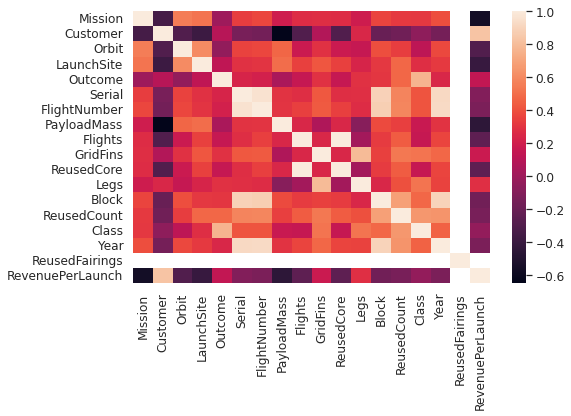

In [40]:
# Kendall's tau heatmap of correlation coefficients
kcorr = df_p.corr(method = 'kendall')
# heatmap
sns.heatmap(kcorr)

* tau shows a strong relationship between Customer and Revenue per launch

In [41]:
# look at customer and revenue per launch
# calculate kendall's correlation
coef, p = kendalltau(df_p['RevenuePerLaunch'], df_p['Customer'])
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
 print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
 print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: 0.829
Samples are correlated (reject H0) p=0.000


Revenue per launch relationships:
* Customer is correlated strongly
* Payload mass is correlated for private customers

<a id="section-three"></a>
### Financial Calculations

These are "known" costs and revenue are extrapolated from various sources, such as:

SpaceX website (2020): base price of 62 million for Falcon 9 mission, this was increase to 67 million in March 2022 due to inflation per SpaceX [price sheet](https://www.spacex.com/media/Capabilities&Services.pdf)

> Payload reduction due to reusability of booster & fairing is <40 percent for F9 & recovery & refurb is <10 percent, so you’re roughly even with 2 flights, definitely ahead with 3. 

Elon Musk, Twitter

> You’ve got the boost stage is probably close to 60 percent of the cost, the upper stage is about 20 percent of the cost, fairing is about 10 percent and then about 10 percent which is associated with the launch itself...We may be able to get down to a marginal cost for a Falcon 9 launch down, fully considered, down under 5 million or 6 million

Elon Musk, CNBC

> So we do expect to see a steady reduction in prices, and we already have reduced prices from where they were, from about 60 million to about 50 million for a re-flown booster.

Elon Musk, Q&A with reporter before the block 5 launch

#### Revenue: 62 million (new core) or 50 million (reused core) 
Costs:
* new_core = 30000000 or reuse_core = 250000
* new_second = 10000000 or new_second = 10000000
* new_fairings = 6000000 or reuse_fairings = 750,000
* fuel_other = 4000000 or fuel_other = 4000000

In [42]:
new_core = 30000000
new_second = 10000000
new_fairings = 6000000
reuse_core = 250000
fuel_other = 4000000

Note: Costs and revenue are ever changing

* Mission offerings: [Rideshare program](https://rideshare.spacex.com/search) 
* Changes in component costs: Economic considerations (materials, inflation...competition)
* Changes in reuse success: Innovation and experience (fairing recovery fleet success, etc.)

In [43]:
new_cost = new_core + new_second + new_fairings + fuel_other
reuse_cost = reuse_core + new_second + new_fairings + fuel_other
print("New core launch cost", new_cost, "Reused core launch cost", reuse_cost)

New core launch cost 50000000 Reused core launch cost 20250000


In [44]:
df['RevenueMinus'] = df['ReusedCore'].where(df['ReusedCore'] == 0, (df['RevenuePerLaunch'] - new_cost))
df['RevenueMinus'] = df['ReusedCore'].where(df['ReusedCore'] == 1, (df['RevenuePerLaunch'] - reuse_cost))
df['RevenueOther'] = df.RevenuePerLaunch - df.RevenueMinus
df['RevenueOtherPerKg'] = df.RevenueOther/df.PayloadMass

In [45]:
df['PayloadMass'].describe()

count      28.000000
mean     4310.821429
std      3300.372359
min       350.000000
25%      2246.750000
50%      3023.000000
75%      5801.250000
max      9600.000000
Name: PayloadMass, dtype: float64

In [46]:
df['RevenueMinus'].describe().apply("{0:.5f}".format)

count           28.00000
mean      70761785.89286
std       46676237.71022
min              1.00000
25%       41340000.00000
50%       69550000.00000
75%      119750000.00000
max      129750000.00000
Name: RevenueMinus, dtype: object

In [47]:
df['RevenueOther'].describe().apply("{0:.5f}".format)

count           28.00000
mean      30879642.67857
std       26587859.25071
min       20250000.00000
25%       20250000.00000
50%       20250000.00000
75%       20250000.00000
max      139999999.00000
Name: RevenueOther, dtype: object

In [48]:
df['RevenueOtherPerKg'].describe().apply("{0:.5f}".format)

count       28.00000
mean     13737.37687
std      17069.32554
min       2109.37500
25%       5064.87231
50%       7218.30316
75%       9520.84633
max      70814.36469
Name: RevenueOtherPerKg, dtype: object

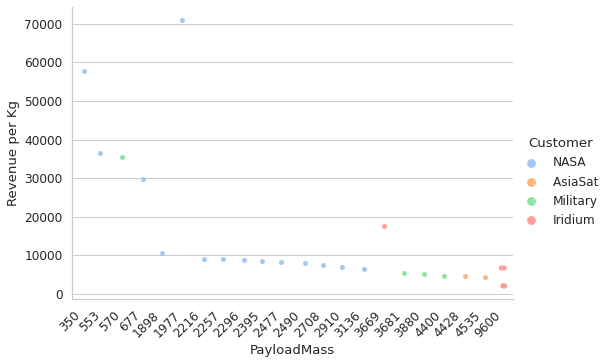

In [49]:
sns.catplot(y = 'RevenueOtherPerKg', x = 'PayloadMass', hue = 'Customer', data=df, height=5, aspect=1.5)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Revenue per Kg')
plt.xticks(rotation=45, ha='right')
plt.show()

As estimated 10,000 per kg (or 0.01 million per kg) seems appropriate to calculate SpaceX charge/revenue per kg in addition to the following costs:
* new_core = 30000000 or reuse_core = 250000
* new_second = 10000000 for all
* new_fairings = 6000000 or reuse_fairings = 750000
* fuel_other = 4000000 for all

In [50]:
AverageCost = (new_cost + reuse_cost)/2
AverageCost

35125000.0

In [51]:
df['RevenuePerLaunch'].describe().apply("{0:.5f}".format)

count           28.00000
mean     101641428.57143
std       36407745.99249
min       52200000.00000
25%       64720000.00000
50%       92600000.00000
75%      140000000.00000
max      150000000.00000
Name: RevenuePerLaunch, dtype: object

In [52]:
AverageRevenue = 101641428.57

In [53]:
AllocationPattern = df['RevenueOther'].mean()/AverageRevenue
AllocationPattern

0.30380960906413035

An allocation to revenue estimate of 30%, and 70% to cost seems appropriate

<a id="subsection-four"></a>
## Evaluation of Estimates
* Compare estimates made from "financial calculations" to contract data

In [54]:
#load the spacex dataframe
sp_df = pd.read_csv('/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex.csv')

In [55]:
# merge estimates of spacex csv df Revenue Total Mil with contract df on FlightNumber
merge_df = df.merge(sp_df[['RevenueTotalMil', 'FlightNumber']], on = 'FlightNumber', how = 'left')

In [56]:
merge_df.shape

(28, 22)

In [57]:
# create a new column with the difference between estimates and actual
merge_df['ResidualRevenue'] = merge_df['RevenueTotalMil'] - merge_df['RevenuePerLaunch']

<AxesSubplot:xlabel='FlightNumber', ylabel='ResidualRevenue'>

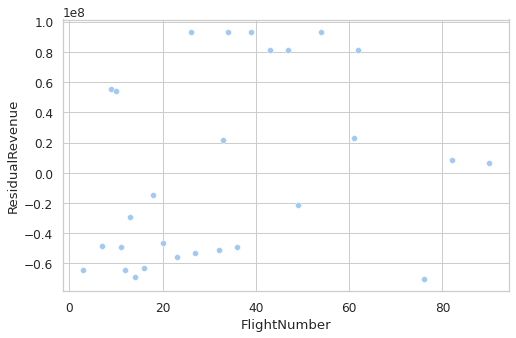

In [58]:
# visual residuals from estimates
sns.scatterplot(x='FlightNumber', y='ResidualRevenue', data = merge_df)

In [59]:
merge_df['ResidualRevenue'].describe().apply("{0:.5f}".format)

count           28.00000
mean       1323928.57143
std       61754004.59885
min      -70230000.00000
25%      -51465000.00000
50%      -17985000.00000
75%       61682500.00000
max       93280000.00000
Name: ResidualRevenue, dtype: object

* the known per launch revenue and estimated revenue based on extrapolation of costs and allocation patterns provided an mean residual of +1.3 million (mean -17 million) with a standard deviation of 61.8 million

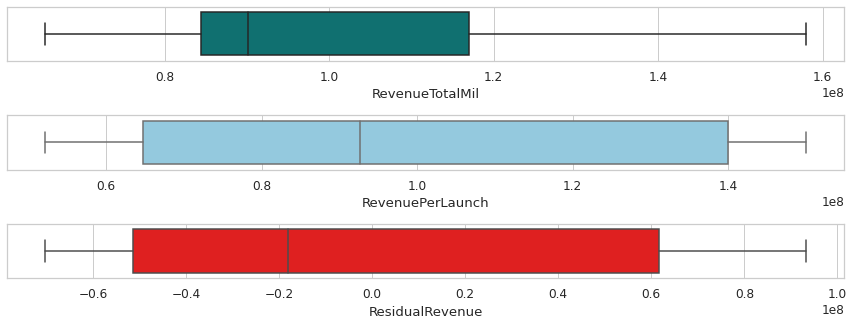

In [60]:
# look at distributions of residual and components
fig, axs = plt.subplots(3, 1, figsize=(15, 5))
fig.subplots_adjust(hspace=1, wspace=0.125)

sns.boxplot(data=merge_df, x="RevenueTotalMil", color="teal", ax=axs[0]) # estimate
sns.boxplot(data=merge_df, x="RevenuePerLaunch", color="skyblue", ax=axs[1]) # from contract
sns.boxplot(data=merge_df, x="ResidualRevenue", color="red", ax=axs[2]) # difference

plt.show()

* the range of estimated and actual revenue is similar
* the IQR of estimates is much smaller than actual
* the residuals seem to reflect the unbalanced nature of the contract amounts
* more factors than those used are at play: used payload mass, reused core, reused fairings in cost extrapolations 

[see metadata for details](https://www.kaggle.com/datasets/brittasmith/spacextoy-dataanalysis-launchprediction?select=SpaceX+Metadata.docx)

<a id="section-robust"></a>
# Robust Regression and LOOCV
* explore another method of predicting revenue per launch
 - use LOOCV to account for small size of dataset, k = n
 - use models that do not assume normal distribution, data is not well behaved
 - use models that account for, expect, outliers

In [61]:
# prepare data
# load merged contract information
df = pd.read_csv("/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex_contracts_customers_known_revenue.csv")
# organize data, eliminate columns not needed
categorical = ['Mission','Customer', 'Orbit', 'LaunchSite', 'Outcome', 'Serial']
numeric = ['FlightNumber','PayloadMass', 'Flights', 'GridFins', 'ReusedCore', 'Legs', 
           'Block', 'ReusedCount', 'Class', 'Year', 'ReusedFairings']
target = ['RevenuePerLaunch']
# join the 
df = df[categorical + numeric + target]

In [63]:
# import processing tools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# encode data to numerical
enc = df.apply(LabelEncoder().fit_transform)
# normalize as not normally distributed
mms = MinMaxScaler()
encmms = mms.fit_transform(enc)
# create dataframe of encmms array
df_x = pd.DataFrame(encmms)
# add back column names
cnames = ['Mission', 'Customer', 'Orbit', 'LaunchSite', 'Outcome', 'Serial',
       'FlightNumber', 'PayloadMass', 'Flights', 'GridFins', 'ReusedCore',
       'Legs', 'Block', 'ReusedCount', 'Class', 'Year', 'ReusedFairings',
       'RevenuePerLaunch']
df_x.columns = cnames
df_x.head()

,Mission,Customer,Orbit,LaunchSite,Outcome,Serial,FlightNumber,PayloadMass,Flights,GridFins,ReusedCore,Legs,Block,ReusedCount,Class,Year,ReusedFairings,RevenuePerLaunch
0,0.4,1.0,0.6,0.0,0.500000,0.000000,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.777778
1,0.4,1.0,0.6,0.0,0.833333,0.041667,0.037037,0.380952,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.142857,0.0,0.777778
2,0.0,0.0,0.2,0.0,0.500000,0.083333,0.074074,0.952381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.000000
3,0.1,0.0,0.2,0.0,0.500000,0.166667,0.111111,0.904762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.000000
4,0.4,1.0,0.6,0.0,0.166667,0.125000,0.148148,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.777778


In [64]:
# prepare data
y = df_x['RevenuePerLaunch']
X = df_x.iloc[:,:-1]

>Linear 0.114 (0.096)
>Huber 0.129 (0.101)
>RANSAC 0.116 (0.107)
>TheilSen 0.119 (0.108)


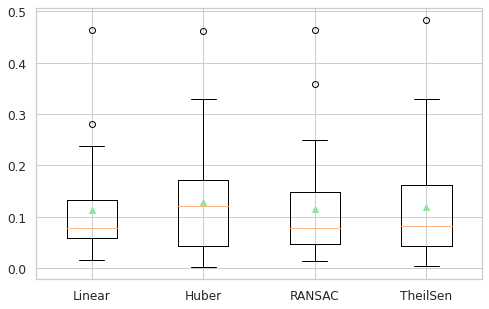

In [65]:
# compare robust regression algorithms on a regression dataset with outliers
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor

# dictionary of model names and model objects
def get_models():
    models = dict()
    models['Linear'] = LinearRegression()
    models['Huber'] = HuberRegressor()
    models['RANSAC'] = RANSACRegressor()
    models['TheilSen'] = TheilSenRegressor()
    return models

# evaluate a model
def evalute_model(X, y, model, name):
    # define model evaluation method
    cv = LeaveOneOut() # create LOOCV procedure
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    scores = absolute(scores) # force scores to be positive
    return scores

# retrieve models
models = get_models()
results = dict()
for name, model in models.items():
    # evaluate the model
    results[name] = evalute_model(X, y, model, name)
    # summarize progress
    print('>%s %.3f (%.3f)' % (name, mean(results[name]), std(results[name])))

# plot model performance for comparison
plt.boxplot(results.values(), labels=results.keys(), showmeans=True)
plt.show()

* in this case the robust regression models do not outperform the linear regression (not robust) model

In [66]:
# prepare financial estimated merged df for fair MAE comparison (normalize)
df_f = merge_df[['RevenueTotalMil','RevenuePerLaunch']].copy()
mms = MinMaxScaler()
mms_f = mms.fit_transform(df_f)
# create dataframe of encmms array
df_f = pd.DataFrame(mms_f)

In [67]:
y_true = df_f.iloc[:, 1]
y_est = df_f.iloc[:, 0]

In [68]:
# compare with financial calculation estimated predictions
MAE_financialcalcest = mean_absolute_error(y_true,y_est)
MAE_financialcalcest

0.5887219919305808

* 0.589 > Linear regression MAE 0.114 
* Linear regression performs better, makes predictions closer to actual contract amounts, than estimated values based on extrapolated costs and allocation patterns
* taking 'Customer' into account is very important to making an accurate estimate of contract amount

<a id="section-four"></a>
# Conclusions

* Initial Exploration
    - Distribution: Contract dataset lacks features with a normal distribution
    - Notable imbalances: The contract data represents the following to a greater extent: extremes in contract amounts (revenue per launch), lower payload masses, year 2017, new core flights, landing success, new fairing use, public sector customers and the orbits of their missions (NASA)
    - Revenue per launch: Variance is large, but may be converging, public sector customers show highest revenue, larger payload masses seem to pay less when viewed without respect to customer type
* Further Analysis: Looking at the Data by Private and Public Customer Type
    - When data is subset by public and private customers, revenue per launch still does not have a normal distribution
    - Payload mass of public customers appears to be more normally distributed
* Correlation of Variables
    - Private Customers and Payload Mass:  a linear relationship appears likely with higher payload masses paying more, furthermore payload mass appears to be an important feature in determining contract price
    - Public Customers and Payload Mass: a linear relationship does not appear to exist, a trend of higher payloads paying more appears to exist, for public customers payload mass is a less important feature in determining contract price
    - Categorical Variable relationships to Revenue per Launch: there is a strong relationship between customer and revenue per launch
* Financial calculations
    - As estimated 10,000 per kg (or 0.01 million per kg) seems appropriate to calculate SpaceX charge/revenue per kg; and an allocation to revenue estimate of 30%, and 70% to cost seems appropriate
    - Comparison of estimates made from "financial calculations" to contract data reveals a mean residual of 1.3 million (std 61.8 million), the residuals seem to reflect the unbalanced nature of contract amounts, accounting for customer would likely provide better estimates
* Robust Regression and LOOCV
    - Comparison of linear regression to robust regression models in this case did not provide a performance advantage, the MAE of the linear regression model was the least at 0.114, this was also more accurate than the financial calculation estimates based on cost of a launch (MAE 0.589)
    - Taking customer into account with a linear regression model can provide the best estimate of contract amount amongst the methods and models evaluated
* Next Steps
    - Utilizing predictive models with the features of customer and payload mass will provide helpful estimates of contract amount
    - To deploy a model that utilizes customer as a feature, the customer type could be used by filtering out NASA and military customers to categorize missions by customer type; doing so will help the model capture each customer types unique patterns in determining contract amounts
    - Exploration of other regression models and comparing them to linear regression would also be beneficial

Resources:
* [Statistical hypothesis testing](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/)
* [Real Python](https://realpython.com/numpy-scipy-pandas-correlation-python/#correlation)
* [Correlation between variables](https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/)
* [SciPy](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.kendalltau.html)
* [Pandas .corr()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html)
* [LOOCV](https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/)
* [Robust Regression](https://machinelearningmastery.com/robust-regression-for-machine-learning-in-python/)